# Importação das Bibliotecas

In [ ]:
# Bibliotecas
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visual
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

# Pré- processamento e métricas
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier,
)

## 1. Dataset Titanic

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/titanic.csv')
df.set_index("id_passageiro", inplace=True)

In [ ]:
print(f"Tamanho total do dataset: {len(df)} linhas")
df.head()

Tamanho total do dataset: 891 linhas


,sobreviveu,classe_bilhete,genero,idade,irmaos_conjuges_abordo,pais_filhos_abordo,numero_bilhete,preco_bilhete,cabine_numero,local_embarque
id_passageiro,,,,,,,,,,
1,False,3,M,22.0,1,0,A/5 21171,7.2500,NaN,Southampton
2,True,1,F,38.0,1,0,PC 17599,71.2833,C85,Cherbourg
3,True,3,F,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton
4,True,1,F,35.0,1,0,113803,53.1000,C123,Southampton
5,False,3,M,35.0,0,0,373450,8.0500,NaN,Southampton


In [ ]:
colunas = df.columns.tolist()
print(f"Colunas do dataset: {len(colunas)}")
colunas

Colunas do dataset: 10


['sobreviveu',
 'classe_bilhete',
 'genero',
 'idade',
 'irmaos_conjuges_abordo',
 'pais_filhos_abordo',
 'numero_bilhete',
 'preco_bilhete',
 'cabine_numero',
 'local_embarque']

# 2. EDA do Dataset


## 2.1 Verificação das colunas numéricas e categóricas

In [ ]:
numerica = ["idade", "preco_bilhete", "irmaos_conjuges_abordo", "pais_filhos_abordo"]

numerica

['idade', 'preco_bilhete', 'irmaos_conjuges_abordo', 'pais_filhos_abordo']

In [ ]:
categorica = ["classe_bilhete", "genero", "numero_bilhete", "cabine_numero", "local_embarque", "sobreviveu"]

categorica

['classe_bilhete',
 'genero',
 'numero_bilhete',
 'cabine_numero',
 'local_embarque',
 'sobreviveu']

## Quantidade de dados únicos no dataset

In [ ]:
for col in df.columns:
    unicos = df[col].nunique(dropna=True)
    print(f"{col}: {unicos} ")

sobreviveu: 2 
classe_bilhete: 3 
genero: 2 
idade: 88 
irmaos_conjuges_abordo: 7 
pais_filhos_abordo: 7 
numero_bilhete: 681 
preco_bilhete: 248 
cabine_numero: 147 
local_embarque: 3 


## 2.2 Quantos dados faltantes/valor nulo possui o dataset?

In [ ]:
faltantes_nan = df.isnull().sum()

colunas_numericas = df.select_dtypes(include=['int64', 'float64']).columns
faltantes_zero = (df[colunas_numericas] == 0).sum()

print("=== Dados faltantes NaN ===")
print(faltantes_nan[faltantes_nan > 0])

print("\n=== Dados com valor 0  ===")
print(faltantes_zero[faltantes_zero > 0])

total_ausentes = faltantes_nan.sum()
total_zeros = faltantes_zero.sum()

print(f"\nTotal de valores NaN: {total_ausentes}")
print(f"Total de valores 0 (em colunas numéricas): {total_zeros}")

=== Dados faltantes NaN ===
idade             177
cabine_numero     687
local_embarque      2
dtype: int64

=== Dados com valor 0  ===
irmaos_conjuges_abordo    608
pais_filhos_abordo        678
preco_bilhete              15
dtype: int64

Total de valores NaN: 866
Total de valores 0 (em colunas numéricas): 1301


## 2.3 Quais são os outliers?

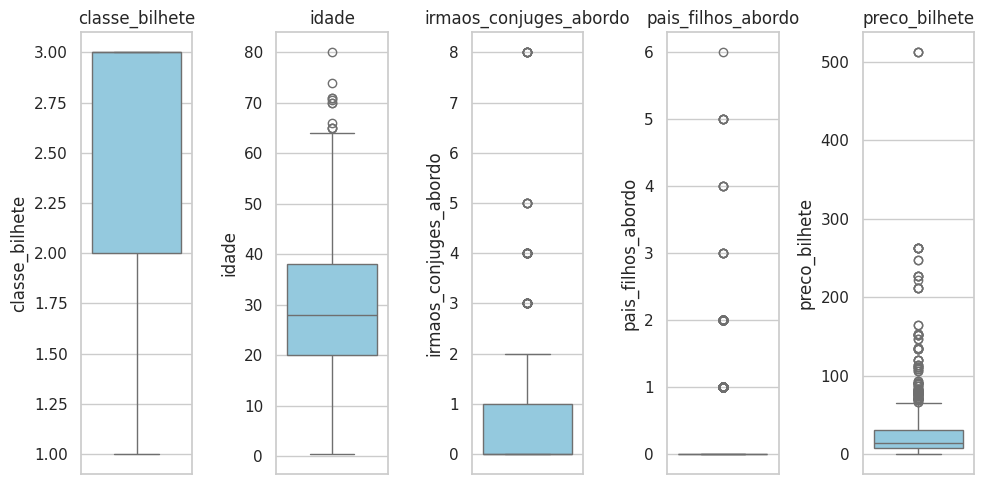

In [ ]:
plt.figure(figsize=(10, 5))
for i, col in enumerate(colunas_numericas, 1):
    plt.subplot(1, len(colunas_numericas), i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()


##2.4 Existe alguma correlação entre essas variáveis numéricas?

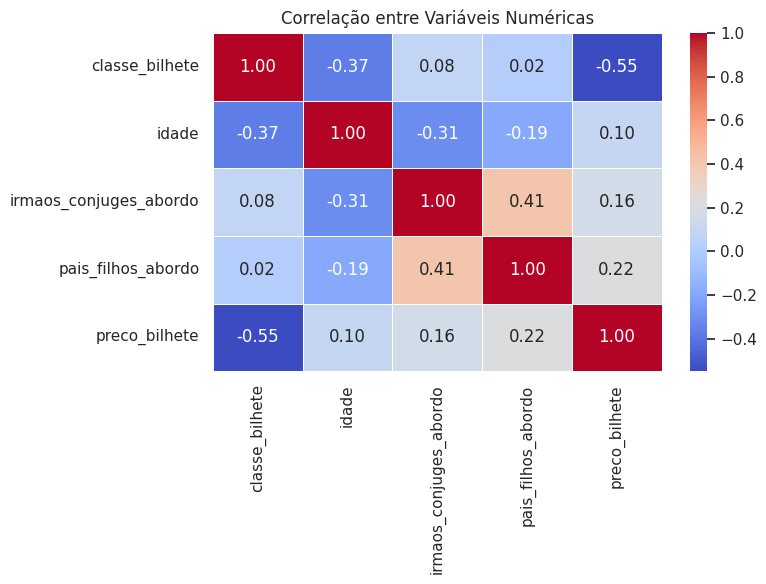

In [ ]:
numericas = df.select_dtypes(include=["number"])

corr = numericas.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlação entre Variáveis Numéricas")
plt.tight_layout()
plt.show()

# Análise dos dados

## 2.4 Quantidade de Irmãos/Conjugues e Pais/irmãos a bordo

                        quantidade
grupo_familia                     
nenhum                         537
apenas irmaos/conjuges         141
apenas pais/filhos              71
ambos                          142


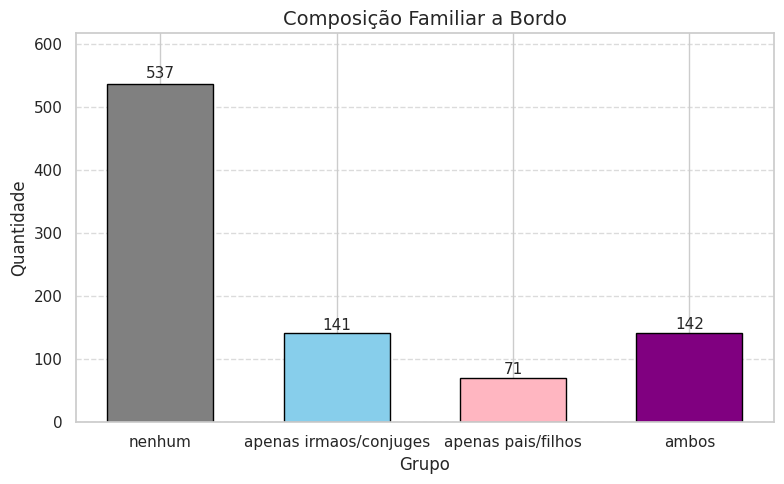

In [ ]:
a = (df['irmaos_conjuges_abordo'].fillna(0) > 0)
b = (df['pais_filhos_abordo'].fillna(0) > 0)

cats = pd.Series(
    np.select(
        condlist=[~a & ~b, a & ~b, ~a & b, a & b],
        choicelist=['nenhum', 'apenas irmaos/conjuges', 'apenas pais/filhos', 'ambos'],
        default='nenhum'
    ),
    name='grupo_familia',
    dtype=object
)

ordem = ['nenhum', 'apenas irmaos/conjuges', 'apenas pais/filhos', 'ambos']
contagens = cats.value_counts().reindex(ordem).fillna(0).astype(int)

print(contagens.to_frame('quantidade'))

plt.figure(figsize=(8,5))
bars = plt.bar(contagens.index, contagens.values,
               color=['gray', 'skyblue', 'lightpink', 'purple'],
               edgecolor='black', width=0.6)

plt.title('Composição Familiar a Bordo', fontsize=14)
plt.xlabel('Grupo', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + (yval * 0.01),
        str(yval),
        ha='center', va='bottom', fontsize=11
    )

plt.ylim(0, max(contagens.values) * 1.15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.5 Distribuição dos Passageiros por Gênero

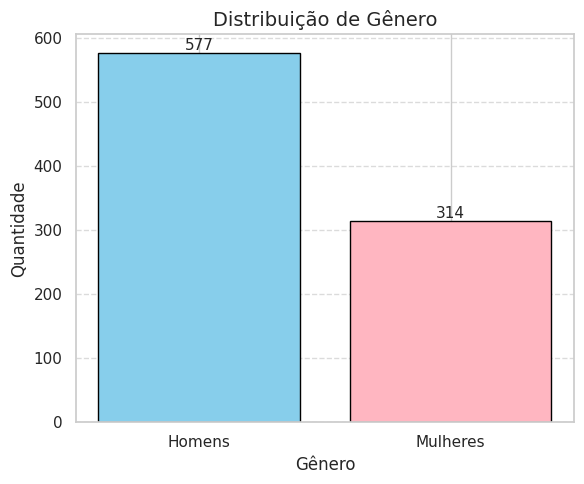

In [ ]:
generos = df['genero'].value_counts()
labels = ['Homens', 'Mulheres']
cores = ['skyblue', 'lightpink']

plt.figure(figsize=(6,5))
plt.bar(labels, generos.values, color=cores, edgecolor='black')
plt.title('Distribuição de Gênero', fontsize=14)
plt.xlabel('Gênero')
plt.ylabel('Quantidade')
for i, v in enumerate(generos.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 2.6 Distribuição de Passageiros por Classes

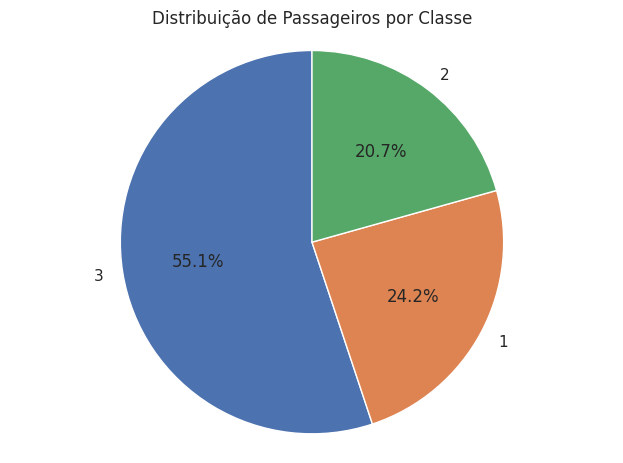

In [ ]:
classe_counts = df['classe_bilhete'].value_counts()

plt.figure()
plt.pie(classe_counts, labels=classe_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Passageiros por Classe')
plt.axis('equal')
plt.tight_layout()
plt.show()

## 2.7 Distribuição das idades dos passageiros

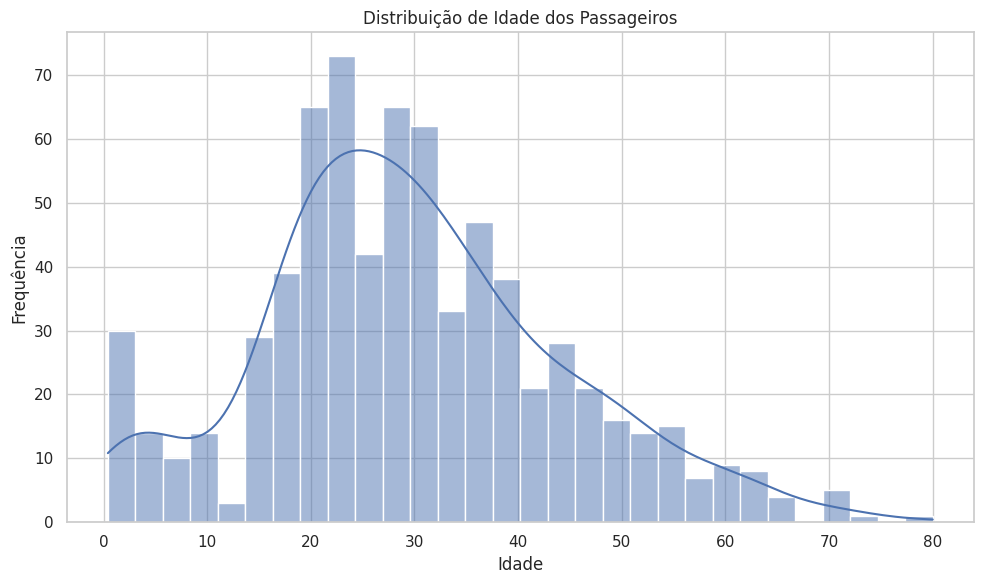

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['idade'], bins=30, kde=True)
plt.title('Distribuição de Idade dos Passageiros')
plt.xlabel('Idade')
plt.ylabel('Frequência')
plt.tight_layout()
plt.show()

## 2.9 Quantas pessoas sobreviveram?

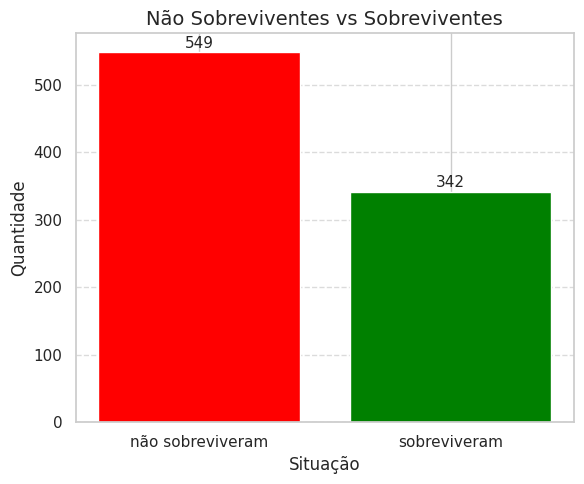

In [ ]:
labels = {0: 'não sobreviveram', 1: 'sobreviveram'}
counts = df['sobreviveu'].value_counts().sort_index()
labels_ordered = [labels[i] for i in counts.index]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels_ordered, counts.values, color=['red', 'green'])

for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        yval + 2,
        f"{yval:,}",
        ha='center', va='bottom', fontsize=11
    )

plt.title('Não Sobreviventes vs Sobreviventes', fontsize=14)
plt.xlabel('Situação', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Análises dos fatores de sobrevivência por coluna

##3.1 Gênero x Sobrevivência

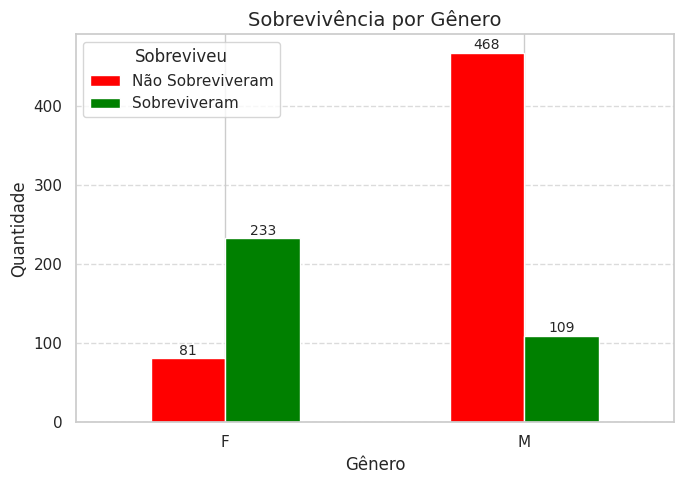

In [ ]:
genero_sobreviventes = df.groupby(['genero', 'sobreviveu']).size().unstack(fill_value=0)

ax = genero_sobreviventes.plot(
    kind='bar',
    color=['red', 'green'],
    figsize=(7, 5)
)

plt.title('Sobrevivência por Gênero', fontsize=14)
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Quantidade', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Sobreviveu', labels=['Não Sobreviveram', 'Sobreviveram'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2, p.get_height() + 1),
        ha='center',
        va='bottom',
        fontsize=10,
    )

plt.tight_layout()
plt.show()

## 2.8 Sobrevivência x Idade

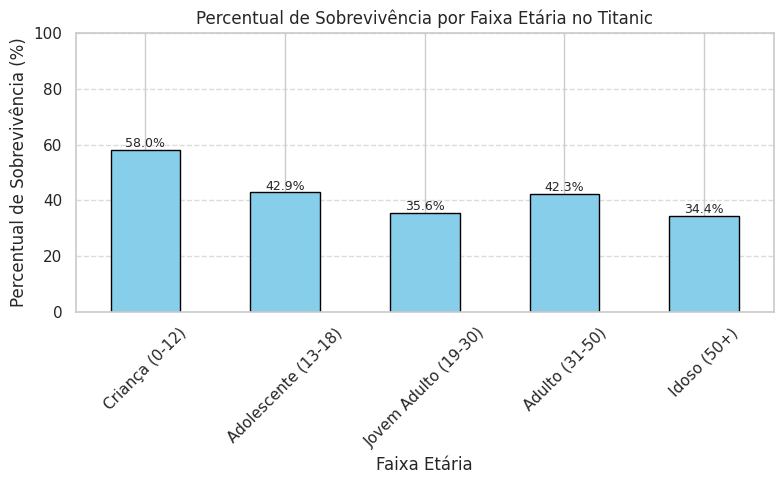

In [ ]:
bins = [0, 12, 18, 30, 50, 120]
labels = ["Criança (0-12)", "Adolescente (13-18)", "Jovem Adulto (19-30)", "Adulto (31-50)", "Idoso (50+)"]
df["faixa_etaria"] = pd.cut(df["idade"], bins=bins, labels=labels, right=True)

percentual = df.groupby("faixa_etaria")["sobreviveu"].mean() * 100

plt.figure(figsize=(8,5))
bars = percentual.plot(kind="bar", color="skyblue", edgecolor="black")
plt.ylabel("Percentual de Sobrevivência (%)")
plt.xlabel("Faixa Etária")
plt.title("Percentual de Sobrevivência por Faixa Etária no Titanic")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)

for i, valor in enumerate(percentual):
    plt.text(i, valor + 1, f"{valor:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

##3.3 Local de Embarque x Sobrevivência

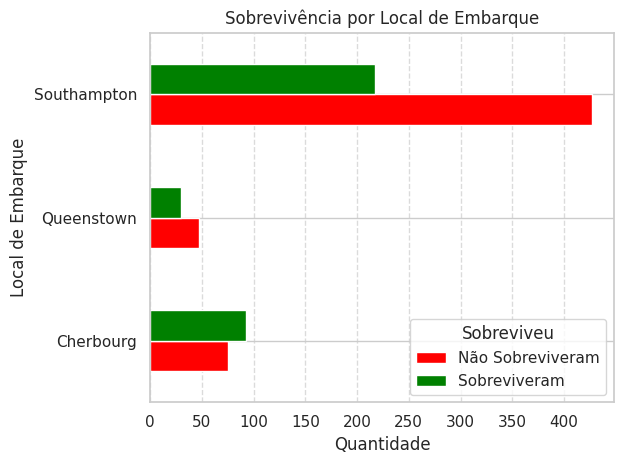

In [ ]:
embarque_sobreviventes = df.groupby(['local_embarque', 'sobreviveu']).size().unstack(fill_value=0)

embarque_sobreviventes.plot(kind='barh', color=['red', 'green'])
plt.title('Sobrevivência por Local de Embarque')
plt.xlabel('Quantidade')
plt.ylabel('Local de Embarque')
plt.legend(title='Sobreviveu', labels=['Não Sobreviveram', 'Sobreviveram'])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Sobrevivência x Classe do Bilhete

<Figure size 800x500 with 0 Axes>

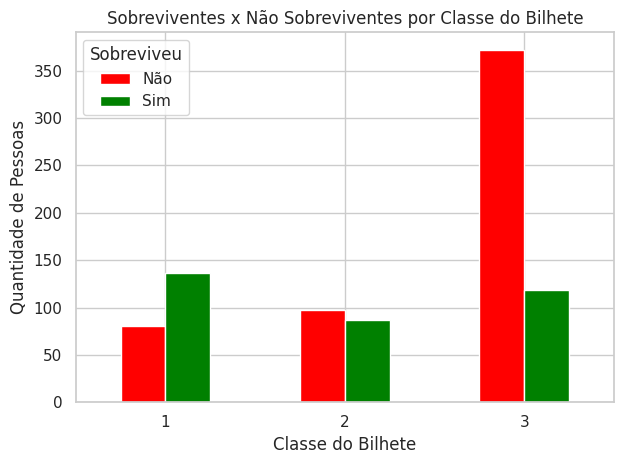

In [ ]:
contagem = df.groupby(["classe_bilhete", "sobreviveu"]).size().unstack(fill_value=0)

plt.figure(figsize=(8, 5))
contagem.plot(kind="bar", stacked=False, color = ["red", "green"])
plt.title("Sobreviventes x Não Sobreviventes por Classe do Bilhete")
plt.xlabel("Classe do Bilhete")
plt.ylabel("Quantidade de Pessoas")
plt.xticks(rotation=0)
plt.legend(title="Sobreviveu", labels=["Não", "Sim"])
plt.tight_layout()
plt.show()

# Recapitulando informações:
- A maioria dos passageiros viajavam sem pais/filhos e irmãos/conjugues;
- Homens era predominância entre os passageiros;
- A 3 classe tinha maior concentração de passageiros;
- A maior taxa de sobrevivência foi de mulheres;
- Os sobreviventes em sua maioria eram crianças e adolescentes seguidos por adultos até 50 anos;
- A maior parte dos sobreviventes embarcaram em Sothampton e Cherbourg;
- A maior taxa de mortalidade pertenceu a pessoas da 3 classe

# Análise das cabines

##  Existe alguma relação entre a classe_bilhete e o cabine_numero ?


In [ ]:
display(df[["classe_bilhete", "cabine_numero"]].head(10))
nao_nulos = df["cabine_numero"].notna().sum()

nulos = df["cabine_numero"].isna().sum()

print(f"Cabine_numero não nulos: {nao_nulos}")
print(f"Cabine_numero nulos: {nulos}")

,classe_bilhete,cabine_numero
id_passageiro,,
1,3,NaN
2,1,C85
3,3,NaN
4,1,C123
5,3,NaN
6,3,NaN
7,1,E46
8,3,NaN
9,3,NaN


Cabine_numero não nulos: 204
Cabine_numero nulos: 687


In [ ]:
total_cabines = (
    df["cabine_numero"]
      .dropna()
      .astype(str)
      .str.split(r"\s+")
      .explode()
      .nunique()
)

print(f"Total de cabines distintas registradas: {total_cabines}")


Total de cabines distintas registradas: 161


# "Setores" do titanic
É um dado já conhecido que o Titanic tinha sessões de cabines divididas entre A - G

* A 1 classe se extendia das cabines A até E
* A 2 classe iam das cabines C a F
* A 3 classe estava nas cabines D a G

## Quais "setores" o dataset possui?

In [ ]:
#primeira letra do número da cabine
df["cabine_setor"] = (
    df["cabine_numero"]
      .astype(str)
      .str.extract(r"([A-Za-z])", expand=False)
      .str.upper()
)
df.loc[df["cabine_numero"].isna(), "cabine_setor"] = pd.NA

setores_unicos = df["cabine_setor"].dropna().unique()
print("Setores de cabine encontrados:", sorted(setores_unicos))

Setores de cabine encontrados: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']


## Como as classes estão distribuídas em relação a esses setores?

In [ ]:
listas = (
    df.loc[df["cabine_setor"].notna()]
      .assign(cabine_setor=lambda d: d["cabine_setor"].astype(str).str.upper().str.extract(r"([A-Z])", expand=False))
      .groupby("classe_bilhete")["cabine_setor"]
      .apply(lambda s: sorted(s.dropna().unique()))
      .reset_index(name="iniciais_disponiveis")
      .sort_values("classe_bilhete")
      .reset_index(drop=True)
)


display(listas)

,classe_bilhete,iniciais_disponiveis
0,1,"[A, B, C, D, E, T]"
1,2,"[D, E, F]"
2,3,"[E, F, G]"


## Quais setores cada classe ocupa

Iniciais de cabine por classe_bilhete


cabine_setor,A,B,C,D,E,F,G,T
classe_bilhete,,,,,,,,
1,15,47,59,29,25,0,0,1
2,0,0,0,4,4,8,0,0
3,0,0,0,0,3,5,4,0


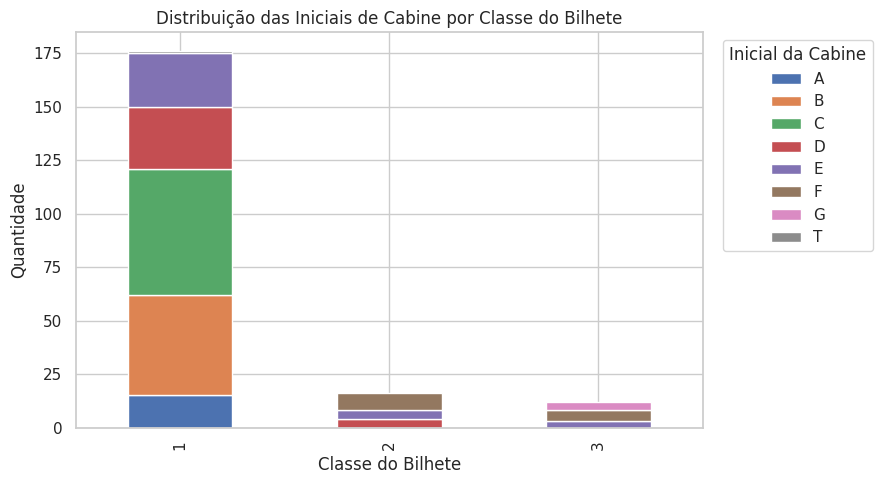

In [ ]:
# Filtra apenas passageiros com setor definido
df_cab = df[df["cabine_setor"].notna()][["classe_bilhete", "cabine_setor"]]

tabela = pd.crosstab(df_cab["classe_bilhete"], df_cab["cabine_setor"]).sort_index(axis=1)
print("Iniciais de cabine por classe_bilhete")
display(tabela)

ax = tabela.plot(kind="bar", stacked=True, figsize=(9, 5))
plt.title("Distribuição das Iniciais de Cabine por Classe do Bilhete")
plt.xlabel("Classe do Bilhete")
plt.ylabel("Quantidade")
plt.legend(title="Inicial da Cabine", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

## Distribuição da sobrevivência pelos setores

Contagem de sobrevivência por Setores:


sobreviveu,Não,Sim
cabine_setor,,
A,8,7
B,12,35
C,24,35
D,8,25
E,8,24
F,5,8
G,2,2
T,1,0


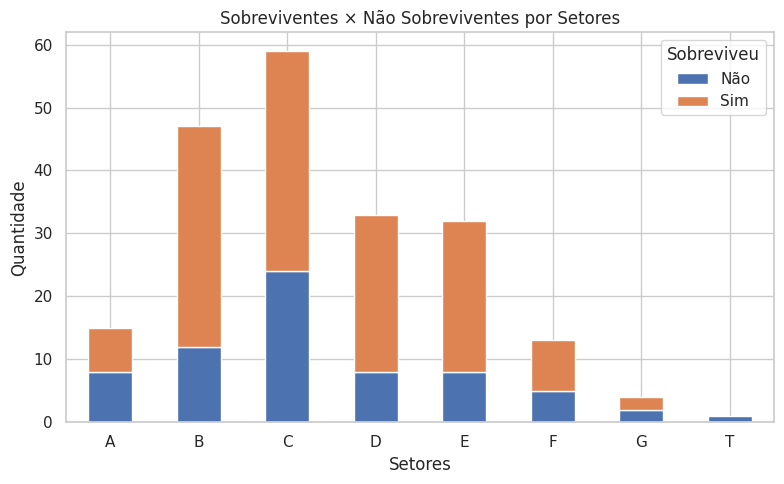

In [ ]:
# cabine_setor x sobrevivencia (0 = Não, 1 = Sim)
tabela = (
    pd.crosstab(df["cabine_setor"], df["sobreviveu"])
      .rename(columns={0: "Não", 1: "Sim"})
      .sort_index()
      .astype(int)
)
print("Contagem de sobrevivência por Setores:")
display(tabela)

ax = tabela.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Sobreviventes × Não Sobreviventes por Setores")
plt.xlabel("Setores")
plt.ylabel("Quantidade")
plt.xticks(rotation=0)
plt.legend(title="Sobreviveu")
plt.tight_layout()
plt.show()

## Conseguimos extrair alguma informação nas colunas numero_bilhete e cabine_numero ?

In [ ]:
display(df[["numero_bilhete", "cabine_numero"]])

,numero_bilhete,cabine_numero
id_passageiro,,
1,A/5 21171,NaN
2,PC 17599,C85
3,STON/O2. 3101282,NaN
4,113803,C123
5,373450,NaN
...,...,...
887,211536,NaN
888,112053,B42
889,W./C. 6607,NaN


## Verificando padrões no numero_bilhete

In [ ]:
df["prefixo_letras"]  = df["numero_bilhete"].astype(str).str.strip().str.extract(r"^([A-Za-z]+)")
df["prefixo_numeros"] = df["numero_bilhete"].astype(str).str.strip().str.extract(r"^(\d+)")

df[["numero_bilhete", "prefixo_letras", "prefixo_numeros"]].head(10)

,numero_bilhete,prefixo_letras,prefixo_numeros
id_passageiro,,,
1,A/5 21171,A,NaN
2,PC 17599,PC,NaN
3,STON/O2. 3101282,STON,NaN
4,113803,NaN,113803
5,373450,NaN,373450
6,330877,NaN,330877
7,17463,NaN,17463
8,349909,NaN,349909
9,347742,NaN,347742


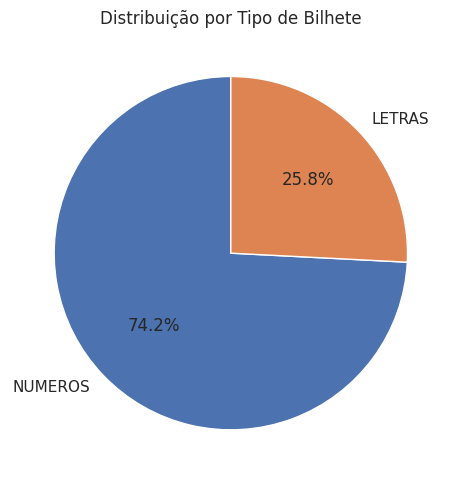

In [ ]:
df["tipo_bilhete"] = np.where(df["prefixo_letras"].notna(), "LETRAS", "NUMEROS")
contagem = df["tipo_bilhete"].value_counts()

plt.figure(figsize=(5,5))
plt.pie(
    contagem.values,
    labels=contagem.index,
    autopct="%1.1f%%",
    startangle=90,
)
plt.title("Distribuição por Tipo de Bilhete")
plt.tight_layout()
plt.show()

## Existe correlação com com as cabines?

In [ ]:
df_distribuicao = df.groupby("cabine_setor").agg({
    "prefixo_letras": lambda x: list(x.dropna().unique()),
    "prefixo_numeros": lambda x: list(x.dropna().unique())
}).reset_index()

display(df_distribuicao)

,cabine_setor,prefixo_letras,prefixo_numeros
0,A,[PC],"[113788, 17764, 113767, 112277, 113056, 33638,..."
1,B,"[PC, WE, F]","[113509, 113572, 111240, 110152, 112059, 11967..."
2,C,[PC],"[113803, 113783, 19950, 19947, 36973, 110465, ..."
3,D,"[PC, SC]","[248698, 35281, 11752, 35273, 11813, 11751, 13..."
4,E,"[W, PC, SOTON, S]","[17463, 27267, 113505, 110413, 226593, 16966, ..."
5,F,[C],"[348123, 2668, 230080, 230136, 248733, 348121,..."
6,G,[PP],[347054]
7,T,[],[113784]


## Existe alguma correlação com as classes?

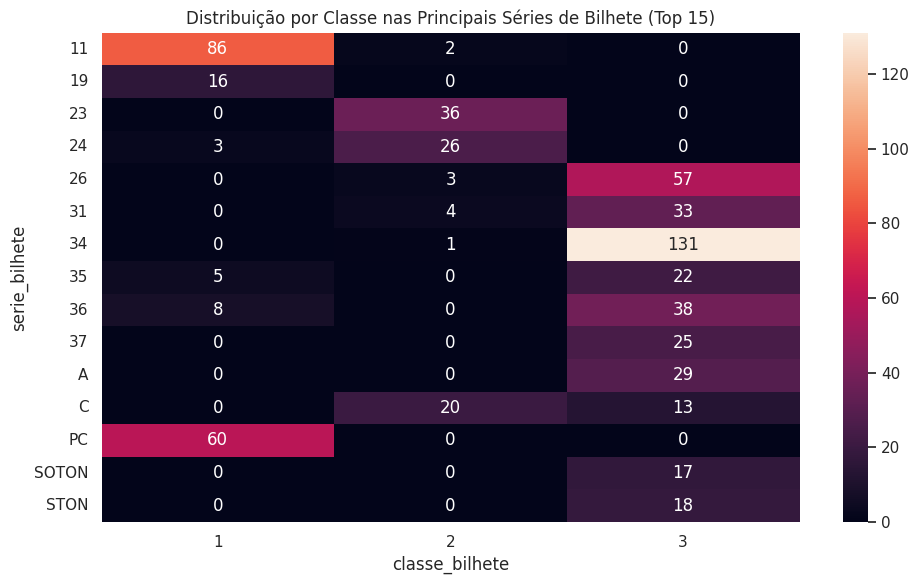

In [ ]:
# Série do bilhete (letras, se não são os 2 primeiros dígitos)
df["serie_bilhete"] = np.where(df["prefixo_letras"].notna(),
                               df["prefixo_letras"].str.upper(),
                               df["prefixo_numeros"].str[:2])

results = {}
for chave in ["numero_bilhete", "serie_bilhete"]:
    cont = (df.groupby([chave, "classe_bilhete"]).size().reset_index(name="qtd"))
    cont["total"] = cont.groupby(chave)["qtd"].transform("sum")
    cont["pct"]   = cont["qtd"] / cont["total"]
    major = (cont.sort_values([chave, "qtd"], ascending=[True, False])
                 .drop_duplicates(chave)
                 .rename(columns={"classe_bilhete":"classe_majoritaria",
                                  "pct":"pct_classe_majoritaria"})
                 [[chave, "classe_majoritaria", "pct_classe_majoritaria", "total"]]
                 .sort_values(["total","pct_classe_majoritaria"], ascending=[False, False])
                 .reset_index(drop=True))
    results[chave] = {
        "cont": cont,
        "major": major,
        "mapa": dict(zip(major[chave], major["classe_majoritaria"]))
    }

tkt_major = results["numero_bilhete"]["major"]
mapa_bilhete_classe = results["numero_bilhete"]["mapa"]
cont_ser = results["serie_bilhete"]["cont"]
ser_major = results["serie_bilhete"]["major"]
mapa_serie_classe = results["serie_bilhete"]["mapa"]

TOP_N = 15
top_series = (cont_ser.groupby("serie_bilhete")["total"].max().nlargest(TOP_N).index)
heat = (cont_ser[cont_ser["serie_bilhete"].isin(top_series)]
        .pivot(index="serie_bilhete", columns="classe_bilhete", values="qtd")
        .fillna(0).astype(int))

plt.figure(figsize=(10, 6))
sns.heatmap(heat, annot=True, fmt="d")
plt.title(f"Distribuição por Classe nas Principais Séries de Bilhete (Top {TOP_N})")
plt.xlabel("classe_bilhete")
plt.ylabel("serie_bilhete")
plt.tight_layout()
plt.show()

## Modelagem dos dados

In [ ]:
#copia pra não mexer no df original
df_prep = df.copy()
df_prep.columns = [c.lower() for c in df_prep.columns]

# CABINE: preenche os faltantes com "Unknown"
df_prep["cabine_setor"] = (
    df_prep["cabine_numero"]
      .astype(str)
      .str.extract(r"([A-Za-z])", expand=False)
      .str.upper()
)
df_prep.loc[df_prep["cabine_numero"].isna(), "cabine_setor"] = np.nan
df_prep["cabine_setor"] = df_prep["cabine_setor"].fillna("Unknown")

# LOCAL DE EMBARQUE: preencher com a moda(o mais comum de aparecer)
for col in ["local_embarque"]:
    if col in df_prep.columns and df_prep[col].isna().any():
        modo_emb = df_prep[col].mode(dropna=True).iloc[0]
        df_prep[col] = df_prep[col].fillna(modo_emb)

# PREÇO DO BILHETE: trata zeros como faltantes e imputa a mediana neles por (classe, embarque)
zeros_fare = (df_prep["preco_bilhete"] == 0).sum() if "preco_bilhete" in df_prep else 0
if "preco_bilhete" in df_prep:

    for col in ["preco_bilhete"]:
        if col in df_prep.columns:
            df_prep.loc[df_prep[col] == 0, col] = np.nan

    # mediana por (classe_bilhete, local_embarque) e substituo onde NaN
    grp_fare = df_prep.groupby(["classe_bilhete", "local_embarque"])["preco_bilhete"].transform("median")
    df_prep["preco_bilhete"] = df_prep["preco_bilhete"].fillna(grp_fare)

    # normalização log para reduzir valores outliers
    df_prep["log_preco_bilhete"] = np.log1p(df_prep["preco_bilhete"])

# IDADE — imputa pela mediana no grupo (classe_bilhete × genero)
grp_age = df_prep.groupby(["classe_bilhete", "genero"])["idade"].transform("median")
df_prep["idade"] = df_prep["idade"].fillna(grp_age)

# FAMÍLIA: mantem os zeros(quem tava sozinho) e cria features úteis
if {"irmaos_conjuges_abordo","pais_filhos_abordo"}.issubset(df_prep.columns):
    # preenche NaN com 0
    for col in ["irmaos_conjuges_abordo","pais_filhos_abordo"]:
        df_prep[col] = df_prep[col].fillna(0)
    df_prep["tamanho_familia"] = df_prep["irmaos_conjuges_abordo"] + df_prep["pais_filhos_abordo"] + 1
    df_prep["estava_sozinho"] = (df_prep["tamanho_familia"] == 1).astype(int)

# MULHER/CRIANÇA (prioridade histórica): 1 se (feminino) OU (idade < 12)
if {"genero", "idade"}.issubset(df_prep.columns):
    genero_fem = df_prep["genero"].astype(str).str.strip().str.lower().isin(
        ["F","f"]
    )
    crianca = df_prep["idade"] < 12
    df_prep["mulher_ou_crianca"] = (genero_fem | crianca).astype(int)

relatorio = {
    "NaN idade (antes)": int(df["idade"].isna().sum()) if "idade" in df.columns else None,
    "NaN idade (depois)": int(df_prep["idade"].isna().sum()) if "idade" in df_prep.columns else None,
    "Zeros em preco_bilhete (antes)": int(zeros_fare),
    "NaN preco_bilhete (depois)": int(df_prep["preco_bilhete"].isna().sum()) if "preco_bilhete" in df_prep else None,
    "NaN local_embarque (depois)": int(df_prep["local_embarque"].isna().sum()),
    "Cabine_setor 'Unknown' (contagem)": int((df_prep["cabine_setor"]=="Unknown").sum()),
}
display(relatorio)

num_cols = [c for c in [
    "idade","preco_bilhete","log_preco_bilhete","tamanho_familia",
    "irmaos_conjuges_abordo","pais_filhos_abordo","mulher_ou_crianca"
] if c in df_prep.columns]

cat_cols = [c for c in ["genero","classe_bilhete","local_embarque","cabine_setor"]
            if c in df_prep.columns]

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

{'NaN idade (antes)': 177,
 'NaN idade (depois)': 0,
 'Zeros em preco_bilhete (antes)': 15,
 'NaN preco_bilhete (depois)': 0,
 'NaN local_embarque (depois)': 0,
 "Cabine_setor 'Unknown' (contagem)": 687}

Numéricas: ['idade', 'preco_bilhete', 'log_preco_bilhete', 'tamanho_familia', 'irmaos_conjuges_abordo', 'pais_filhos_abordo', 'mulher_ou_crianca']
Categóricas: ['genero', 'classe_bilhete', 'local_embarque', 'cabine_setor']


In [ ]:
df_prep.head()

,sobreviveu,classe_bilhete,genero,idade,irmaos_conjuges_abordo,pais_filhos_abordo,numero_bilhete,preco_bilhete,cabine_numero,local_embarque,faixa_etaria,cabine_setor,prefixo_letras,prefixo_numeros,tipo_bilhete,serie_bilhete,log_preco_bilhete,tamanho_familia,estava_sozinho,mulher_ou_crianca
id_passageiro,,,,,,,,,,,,,,,,,,,,
1,False,3,M,22.0,1,0,A/5 21171,7.2500,NaN,Southampton,Jovem Adulto (19-30),Unknown,A,NaN,LETRAS,A,2.110213,2,0,0
2,True,1,F,38.0,1,0,PC 17599,71.2833,C85,Cherbourg,Adulto (31-50),C,PC,NaN,LETRAS,PC,4.280593,2,0,1
3,True,3,F,26.0,0,0,STON/O2. 3101282,7.9250,NaN,Southampton,Jovem Adulto (19-30),Unknown,STON,NaN,LETRAS,STON,2.188856,1,1,1
4,True,1,F,35.0,1,0,113803,53.1000,C123,Southampton,Adulto (31-50),C,NaN,113803,NUMEROS,11,3.990834,2,0,1
5,False,3,M,35.0,0,0,373450,8.0500,NaN,Southampton,Adulto (31-50),Unknown,NaN,373450,NUMEROS,37,2.202765,1,1,0


## Retirada de alguns dados para organização

In [ ]:
cols_to_drop = ["faixa_etaria", "prefixo_letras", "prefixo_numeros", "cabine_numero","tipo_bilhete"]

removidas = [c for c in cols_to_drop if c in df_prep.columns]
df_prep.drop(columns=removidas, inplace=True)

print("Removidas de df_prep:", removidas)


Removidas de df_prep: ['faixa_etaria', 'prefixo_letras', 'prefixo_numeros', 'cabine_numero', 'tipo_bilhete']


In [ ]:
df_prep.head()

,sobreviveu,classe_bilhete,genero,idade,irmaos_conjuges_abordo,pais_filhos_abordo,numero_bilhete,preco_bilhete,local_embarque,cabine_setor,serie_bilhete,log_preco_bilhete,tamanho_familia,estava_sozinho,mulher_ou_crianca
id_passageiro,,,,,,,,,,,,,,,
1,False,3,M,22.0,1,0,A/5 21171,7.2500,Southampton,Unknown,A,2.110213,2,0,0
2,True,1,F,38.0,1,0,PC 17599,71.2833,Cherbourg,C,PC,4.280593,2,0,1
3,True,3,F,26.0,0,0,STON/O2. 3101282,7.9250,Southampton,Unknown,STON,2.188856,1,1,1
4,True,1,F,35.0,1,0,113803,53.1000,Southampton,C,11,3.990834,2,0,1
5,False,3,M,35.0,0,0,373450,8.0500,Southampton,Unknown,37,2.202765,1,1,0


## Treinamento dos modelos

Numéricas usadas: ['idade', 'preco_bilhete', 'log_preco_bilhete', 'tamanho_familia', 'irmaos_conjuges_abordo', 'pais_filhos_abordo', 'mulher_ou_crianca']
Categóricas usadas: ['classe_bilhete', 'genero', 'local_embarque', 'cabine_setor']

=== Validação Cruzada (AUC) ===
 model   cv_auc                                                                                                                                                                         best_params
LogReg 0.865082                                                                                                        {'clf__C': 0.5, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear'}
    RF 0.863307 {'clf__class_weight': 'balanced_subsample', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}
   HGB 0.860623                                                                                                   {'clf__learning_rate': 0.05,

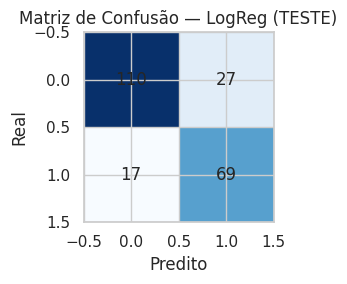

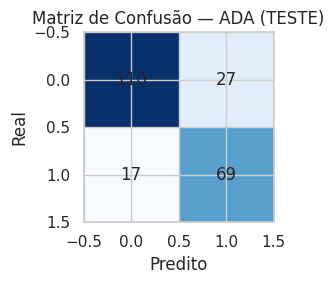

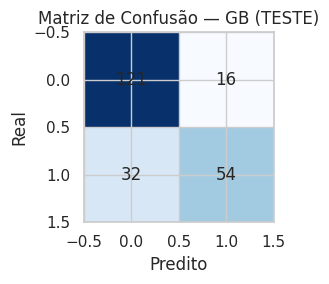

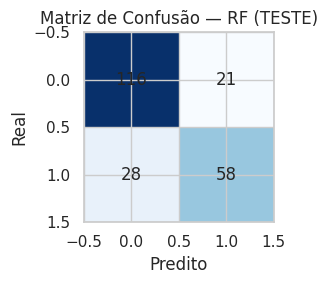

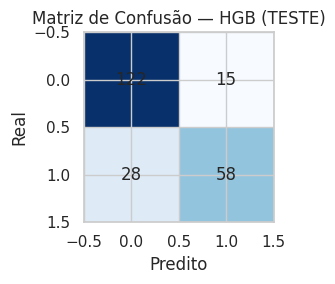

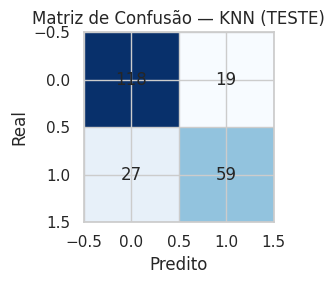

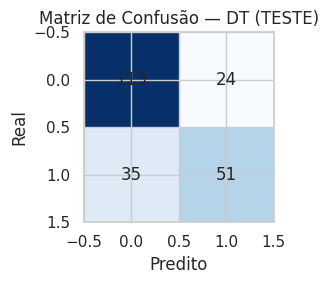

In [ ]:
# Seleção das features
dfx = df_prep.copy()
y = dfx["sobreviveu"].astype(int)

num_cols = [c for c in [
    "idade",
    "preco_bilhete",
    "log_preco_bilhete",
    "tamanho_familia",
    "irmaos_conjuges_abordo",
    "pais_filhos_abordo",
    "mulher_ou_crianca",
] if c in dfx.columns]

cat_cols = [c for c in [
    "classe_bilhete",
    "genero",
    "local_embarque",
    "cabine_setor",
] if c in dfx.columns]

X = dfx[num_cols + cat_cols].copy()

print("Numéricas usadas:", num_cols)
print("Categóricas usadas:", cat_cols)


# OneHot compatível (sklearn varia)

def make_ohe(sparse: bool):
    try:
        return OneHotEncoder(handle_unknown="infrequent_if_exist",
                             min_frequency=0.01,
                             sparse_output=sparse)
    except TypeError:
        try:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=sparse)
        except TypeError:
            return OneHotEncoder(handle_unknown="ignore", sparse=sparse)


# Pré-processamento (num: imput/escala; cat: imput/OHE)
prep_scaled = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                          ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", make_ohe(True))]), cat_cols),
    ],
    remainder="drop"
)

prep_tree = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", make_ohe(True))]), cat_cols),
    ],
    remainder="drop"
)

prep_dense = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                          ("ohe", make_ohe(False))]), cat_cols),
    ],
    remainder="drop"
)

# Pipelines por modelo
pipes = {
    "LogReg": Pipeline([("prep", prep_scaled), ("clf", LogisticRegression(max_iter=2000))]),
    "KNN":    Pipeline([("prep", prep_scaled), ("clf", KNeighborsClassifier())]),

    "DT":     Pipeline([("prep", prep_tree),   ("clf", DecisionTreeClassifier(random_state=42))]),
    "RF":     Pipeline([("prep", prep_tree),   ("clf", RandomForestClassifier(random_state=42))]),

    "GB":     Pipeline([("prep", prep_dense),  ("clf", GradientBoostingClassifier(random_state=42))]),
    "HGB":    Pipeline([("prep", prep_dense),  ("clf", HistGradientBoostingClassifier(random_state=42))]),
    "ADA":    Pipeline([("prep", prep_dense),  ("clf", AdaBoostClassifier(random_state=42))]),
}

# Hiperparametros de cada modelo para melhorar o resultado
param_grids = {
    "LogReg": {
        "clf__solver": ["liblinear"],
        "clf__C": [0.5, 1.0],
        "clf__class_weight": ["balanced"],
    },
    "KNN": {
        "clf__n_neighbors": [11],
        "clf__weights": ["distance"],
        "clf__p": [2],
    },
    "DT": {
        "clf__criterion": ["entropy"],
        "clf__max_depth": [10],
        "clf__min_samples_leaf": [2],
    },
    "RF": {
        "clf__n_estimators": [400],
        "clf__max_depth": [None],
        "clf__min_samples_leaf": [2],
        "clf__min_samples_split": [2],
        "clf__max_features": ["sqrt"],
        "clf__class_weight": ["balanced_subsample"],
    },
    "GB": {
        "clf__learning_rate": [0.05],
        "clf__n_estimators": [200],
        "clf__max_depth": [3],
    },
    "HGB": {
        "clf__learning_rate": [0.05],
        "clf__max_depth": [None],
        "clf__min_samples_leaf": [20],
    },
    "ADA": {
        "clf__n_estimators": [200],
        "clf__learning_rate": [1.0],
    },
}
# divisão treino 75% e teste 25%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

best_estimators, rows_cv = {}, []
for name, pipe in pipes.items():
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="roc_auc",
        refit=True,
        cv=cv,
        n_jobs=-1,
        verbose=0
    )
    gs.fit(X_train, y_train)
    best = gs.best_estimator_
    best_estimators[name] = best
    rows_cv.append({"model": name, "cv_auc": gs.best_score_, "best_params": gs.best_params_})

cv_df = pd.DataFrame(rows_cv).sort_values("cv_auc", ascending=False).reset_index(drop=True)

# 7) Avaliação organizada (TREINO e TESTE)
#    - AUC com predict_proba/decision_function quando houver
def _proba_like(est, X):
    if hasattr(est, "predict_proba"):
        return est.predict_proba(X)[:, 1]
    if hasattr(est, "decision_function"):
        dec = est.decision_function(X)
        # min-max para [0,1] só para poder calcular AUC
        return (dec - dec.min()) / (dec.max() - dec.min() + 1e-12)
    # fallback (raro)
    return est.predict(X)

# metricas
def eval_block(est, X, y):
    y_hat = est.predict(X)
    p = _proba_like(est, X)
    return {
        "roc_auc": roc_auc_score(y, p),
        "accuracy": accuracy_score(y, y_hat),
        "precision": precision_score(y, y_hat, zero_division=0),
        "recall": recall_score(y, y_hat, zero_division=0),
        "f1": f1_score(y, y_hat, zero_division=0),
    }, y_hat

rows_train, rows_test = [], []
yhat_test_by_model = {}

for name, est in best_estimators.items():
    m_train, _ = eval_block(est, X_train, y_train)
    m_test,  yhat = eval_block(est, X_test,  y_test)

    m_train["model"] = name
    m_test["model"]  = name
    rows_train.append(m_train)
    rows_test.append(m_test)
    yhat_test_by_model[name] = yhat

train_df = pd.DataFrame(rows_train).set_index("model").sort_values("roc_auc", ascending=False)
test_df  = pd.DataFrame(rows_test ).set_index("model").sort_values("roc_auc", ascending=False)

print("\n=== Validação Cruzada (AUC) ===")
print(cv_df.to_string(index=False))

print("\n=== MÉTRICAS — TREINO (ordenado por AUC) ===")
print(train_df.to_string())

print("\n=== MÉTRICAS — TESTE (ordenado por AUC) ===")
print(test_df.to_string())

for name in test_df.index:
    y_hat = yhat_test_by_model[name]
    cm = confusion_matrix(y_test, y_hat)
    plt.figure(figsize=(4,3))
    plt.imshow(cm, cmap="Blues")
    plt.title(f"Matriz de Confusão — {name} (TESTE)")
    plt.xlabel("Predito"); plt.ylabel("Real")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

#Qual o fator que foi mais importante e menos importante para determinar a sobrevivência para esta população?

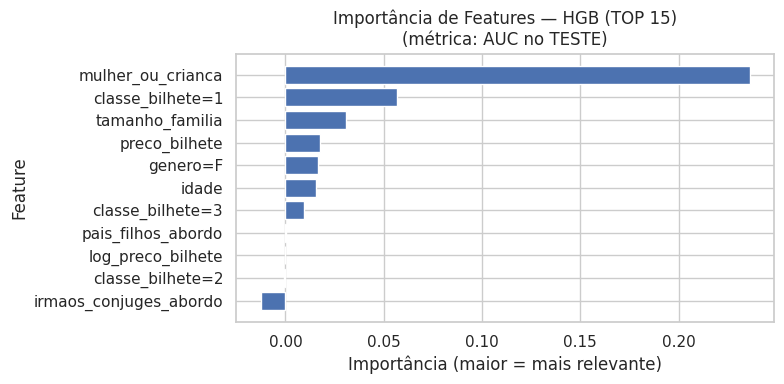

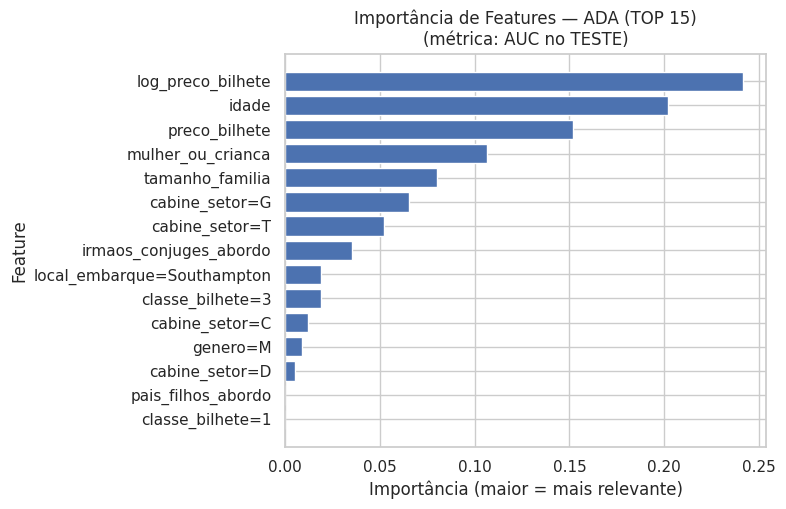

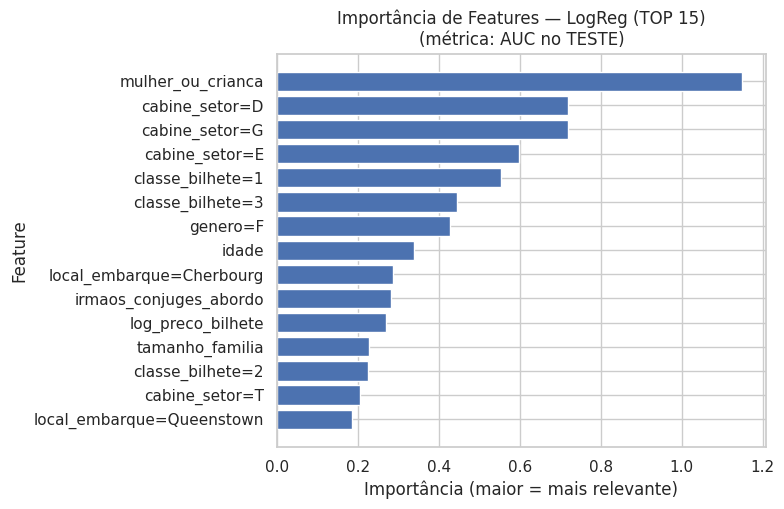

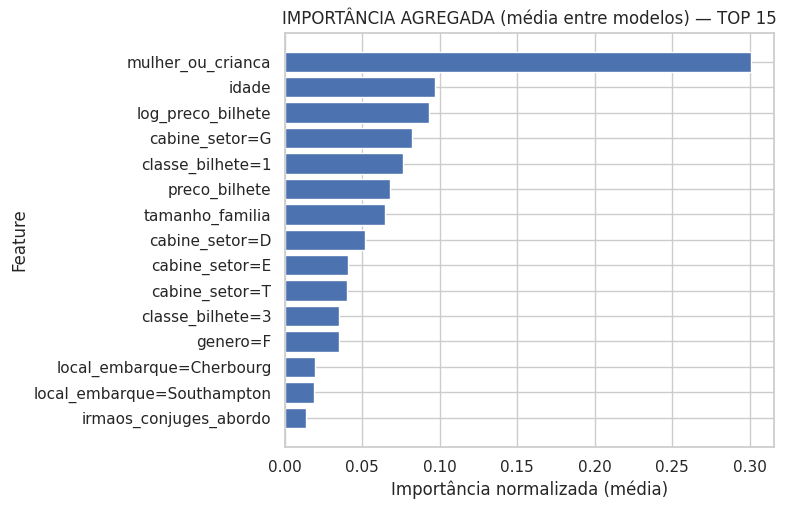

Top 5 importantes:


,feature,importance_norm
19,mulher_ou_crianca,0.300591
13,idade,0.096901
18,log_preco_bilhete,0.092943
6,cabine_setor=G,0.082153
8,classe_bilhete=1,0.076492


In [ ]:
# --- 1) utilitário: nomes das colunas após o pré-processamento ---
def get_feature_names_from_ct(pipeline, num_cols, cat_cols):
    """
    Retorna a lista de nomes das features após o ColumnTransformer do passo 'prep' da pipeline.
    Para numéricas: mantém o nome original.
    Para categóricas (OneHot): cria nomes no formato 'col=valor'.
    """
    ct = pipeline.named_steps["prep"]
    feat_names = []

    # 1. bloco numérico
    if "num" in ct.named_transformers_ and ct.named_transformers_["num"] is not None:
        # mesmo nº de colunas de entrada
        feat_names.extend(list(num_cols))

    # 2. bloco categórico (OneHot dentro de um Pipeline)
    if "cat" in ct.named_transformers_ and ct.named_transformers_["cat"] is not None:
        cat_pipe = ct.named_transformers_["cat"]
        # quando é Pipeline: pegue o passo 'ohe'
        try:
            ohe = cat_pipe.named_steps["ohe"]
        except Exception:
            # se não for Pipeline (raro), pode já ser o OHE
            ohe = cat_pipe

        # monta nomes "col=categoria" respeitando a ordem dos cat_cols
        cats = ohe.categories_
        for col, cats_col in zip(cat_cols, cats):
            feat_names.extend([f"{col}={c}" for c in cats_col])

    return feat_names

# --- 2) utilitário: vetor de importância para QUALQUER modelo ---
def feature_importance_any(model, X_test, y_test, scorer="roc_auc", n_repeats=7, random_state=42):
    """
    Retorna um vetor de importâncias alinhado com as colunas pós-'prep' da pipeline.
    Preferências:
      1) feature_importances_ (árvores/ensembles)
      2) |coef_| (modelos lineares)
      3) permutation importance (genérico, mais lento)
    """
    clf = model.named_steps["clf"]

    # 1) Árvores/ensembles com atributo nativo
    if hasattr(clf, "feature_importances_"):
        return np.asarray(clf.feature_importances_, dtype=float)

    # 2) Modelos lineares com coeficientes
    if hasattr(clf, "coef_"):
        coefs = clf.coef_
        # binário: shape (1, n_features) → pega a linha e usa valor absoluto
        if coefs.ndim == 2 and coefs.shape[0] == 1:
            return np.abs(coefs[0])
        # multiclasses: pega a média do |coef| entre classes
        return np.mean(np.abs(coefs), axis=0)

    # 3) Genérico: permutation importance no conjunto de TESTE
    perm = permutation_importance(
        model, X_test, y_test,
        scoring=scorer,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=-1
    )
    return perm.importances_mean


TOP_N = 15
models_to_plot = list(["HGB","ADA","LogReg"]) # ou escolha manual, ex.: ["HGB","RF","LogReg"]

all_importances = []  # para ranking agregado

for name in models_to_plot:
    est = best_estimators[name]
    feat_names = get_feature_names_from_ct(est, num_cols, cat_cols)
    imp = feature_importance_any(est, X_test, y_test, scorer="roc_auc", n_repeats=7, random_state=42)

    # segurança: alinhar tamanhos
    k = min(len(feat_names), len(imp))
    feat_names = feat_names[:k]
    imp = np.asarray(imp[:k], dtype=float)

    df_imp = pd.DataFrame({"feature": feat_names, "importance": imp})
    df_imp = df_imp.sort_values("importance", ascending=False)

    # guarda uma versão normalizada para o ranking agregado
    s = df_imp["importance"].sum()
    if s <= 0:
        # evita divisão por zero (caso raro)
        df_imp["importance_norm"] = 0.0
    else:
        df_imp["importance_norm"] = df_imp["importance"] / s
    df_imp["model"] = name
    all_importances.append(df_imp[["model","feature","importance_norm"]])

    # --- Plot TOP_N deste modelo ---
    top = df_imp.head(TOP_N).iloc[::-1]  # inverte p/ barh subir
    plt.figure(figsize=(8, max(4, 0.35*len(top))))
    plt.barh(top["feature"], top["importance"])
    plt.title(f"Importância de Features — {name} (TOP {TOP_N})\n(métrica: AUC no TESTE)")
    plt.xlabel("Importância (maior = mais relevante)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# --- 4) Ranking agregado entre modelos (média das importâncias normalizadas) ---
if all_importances:
    agg = (
        pd.concat(all_importances, ignore_index=True)
          .groupby("feature", as_index=False)["importance_norm"].mean()
          .sort_values("importance_norm", ascending=False)
    )
    topA = agg.head(TOP_N).iloc[::-1]
    plt.figure(figsize=(8, max(4, 0.35*len(topA))))
    plt.barh(topA["feature"], topA["importance_norm"])
    plt.title(f"IMPORTÂNCIA AGREGADA (média entre modelos) — TOP {TOP_N}")
    plt.xlabel("Importância normalizada (média)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    print("Top 5 importantes:")
    display(agg.head())


## Predizendo para novos passageiros

In [ ]:
# 5 novos passageiros
num_cols = [c for c in [
    "idade","preco_bilhete","log_preco_bilhete",
    "tamanho_familia","irmaos_conjuges_abordo",
    "pais_filhos_abordo","mulher_ou_crianca"
] if c in X.columns]

cat_cols = [c for c in [
    "classe_bilhete","genero","local_embarque","cabine_setor"
] if c in X.columns]

novos = [
    # 1) 1ª classe, mulher adulta, tarifa alta, deck B
    dict(classe_bilhete=1, genero="female", idade=28,
         preco_bilhete=120.0, local_embarque="C",
         irmaos_conjuges_abordo=0, pais_filhos_abordo=0,
         cabine_setor="B"),
    # 2) 3ª classe, menino (criança), família grande, sem cabine conhecida
    dict(classe_bilhete=3, genero="male", idade=8,
         preco_bilhete=15.0, local_embarque="S",
         irmaos_conjuges_abordo=1, pais_filhos_abordo=2,
         cabine_setor="Unknown"),
    # 3) 2ª classe, homem 40 anos, sozinho, deck D
    dict(classe_bilhete=2, genero="male", idade=40,
         preco_bilhete=30.0, local_embarque="S",
         irmaos_conjuges_abordo=0, pais_filhos_abordo=0,
         cabine_setor="D"),
    # 4) 3ª classe, mulher jovem, sozinha, embarque Q
    dict(classe_bilhete=3, genero="female", idade=19,
         preco_bilhete=7.9, local_embarque="Q",
         irmaos_conjuges_abordo=0, pais_filhos_abordo=0,
         cabine_setor="Unknown"),
    # 5) 1ª classe, homem idoso com cônjuge, deck C
    dict(classe_bilhete=1, genero="male", idade=65,
         preco_bilhete=80.0, local_embarque="C",
         irmaos_conjuges_abordo=1, pais_filhos_abordo=0,
         cabine_setor="C"),
]

df_new = pd.DataFrame(novos)

# Criação das features
# tamanho_familia = irmãos/cônjuges + pais/filhos + o próprio passageiro
df_new["tamanho_familia"] = (
    df_new["irmaos_conjuges_abordo"].fillna(0)
    + df_new["pais_filhos_abordo"].fillna(0) + 1
)

# log do preço bilhete
df_new["log_preco_bilhete"] = np.log1p(df_new["preco_bilhete"].fillna(0))

# mulher_ou_crianca (criança < 12 anos ou genero = female)
df_new["mulher_ou_crianca"] = np.where(
    (df_new["genero"].str.lower().str.startswith("f")) | (df_new["idade"] < 12),
    1, 0
)

# 'cabine_setor' conhecido
df_new["cabine_setor"] = df_new["cabine_setor"].fillna("Unknown")

X_new = df_new.reindex(columns=(num_cols + cat_cols))

# modelo
model_name = "HGB"
est = best_estimators[model_name]
y_pred = est.predict(X_new)

if hasattr(est, "predict_proba"):
    proba = est.predict_proba(X_new)[:, 1]
elif hasattr(est, "decision_function"):
    dec = est.decision_function(X_new)

    proba = (dec - dec.min()) / (dec.max() - dec.min() + 1e-12)
else:
    proba = np.full(len(X_new), np.nan)

out = df_new.copy()
out["modelo"] = model_name
out["predito"] = y_pred
out["pred_label"] = np.where(out["predito"] == 1, "Sobreviveu", "Não sobreviveu")
out["prob_sobreviver"] = np.round(proba, 3)

cols_show = [
    "modelo","classe_bilhete","genero","idade","preco_bilhete","local_embarque",
    "irmaos_conjuges_abordo","pais_filhos_abordo","tamanho_familia",
    "cabine_setor","mulher_ou_crianca","pred_label","prob_sobreviver"
]
print("=== Previsões para novos passageiros ===")
display(out[cols_show])


=== Previsões para novos passageiros ===


,modelo,classe_bilhete,genero,idade,preco_bilhete,local_embarque,irmaos_conjuges_abordo,pais_filhos_abordo,tamanho_familia,cabine_setor,mulher_ou_crianca,pred_label,prob_sobreviver
0,HGB,1,female,28,120.0,C,0,0,1,B,1,Sobreviveu,0.981
1,HGB,3,male,8,15.0,S,1,2,4,Unknown,1,Sobreviveu,0.700
2,HGB,2,male,40,30.0,S,0,0,1,D,0,Sobreviveu,0.660
3,HGB,3,female,19,7.9,Q,0,0,1,Unknown,1,Não sobreviveu,0.491
4,HGB,1,male,65,80.0,C,1,0,2,C,0,Não sobreviveu,0.149
